In [1]:
# Libraries
using DataFrames
using CSV
using StatsPlots
using Statistics

using StatsModels
using GLM

In [2]:
# Import data and see first observations
df = CSV.read("../../data/processed_esti.csv", DataFrame)
first(df, 5)

Row,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
2,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
3,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
4,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
5,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3


In [3]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,y,0.351926,0,0.0,1,0,Int64
2,w,0.529615,0,1.0,1,0,Int64
3,gender_female,0.584244,0,1.0,1,0,Int64
4,gender_male,0.413456,0,0.0,1,0,Int64
5,gender_transgender,0.00230017,0,0.0,1,0,Int64
6,ethnicgrp_asian,0.0638298,0,0.0,1,0,Int64
7,ethnicgrp_black,0.0862565,0,0.0,1,0,Int64
8,ethnicgrp_mixed_multiple,0.0885566,0,0.0,1,0,Int64
9,ethnicgrp_other,0.013226,0,0.0,1,0,Int64


In [4]:
control = select(filter(row -> row[:w] == 0, df), Not(:y))
treatment = select(filter(row -> row[:w] == 1, df), Not(:y))

Row,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
2,1,0,1,0,0,1,0,0,0,0,1,0,26,4
3,1,1,0,0,1,0,0,0,0,0,1,0,24,3
4,1,0,1,0,0,0,0,0,1,0,1,0,24,2
5,1,1,0,0,0,0,0,0,1,0,0,0,24,4
6,1,0,1,0,0,0,0,0,1,1,0,0,27,2
7,1,1,0,0,0,1,0,0,0,0,0,0,21,6
8,1,0,1,0,0,0,0,0,1,0,0,1,18,4
9,1,0,1,0,0,0,0,0,1,1,1,1,26,2


In [5]:
using DataFrames, Statistics

# Function to get descriptive statistics
function get_descriptive_stats(group::DataFrame, column::Symbol)
    if column == :age
        count_val = count(!ismissing, group[:, column])
    else
        count_val = sum(group[:, column] .== 1)
    end
    mean_val = mean(group[:, column])
    std_val = std(group[:, column])
    return count_val, mean_val, std_val
end

get_descriptive_stats (generic function with 1 method)

In [6]:
variables = setdiff(Symbol.(names(df)), [:w, :y])
control_stats = Dict(var => get_descriptive_stats(control, var) for var in variables)
treatment_stats = Dict(var => get_descriptive_stats(treatment, var) for var in variables)

# Convert the dictionary to a DataFrame
control_df = DataFrame(
    Variable = collect(keys(control_stats)),
    Count = [val[1] for val in values(control_stats)],
    Mean = [val[2] for val in values(control_stats)],
    Std = [val[3] for val in values(control_stats)]
)
treatment_df = DataFrame(
    Variable = collect(keys(treatment_stats)),
    Count = [val[1] for val in values(treatment_stats)],
    Mean = [val[2] for val in values(treatment_stats)],
    Std = [val[3] for val in values(treatment_stats)]
)
control_df = sort!(control_df, :Variable)
treatment_df = sort!(treatment_df, :Variable)


Row,Variable,Count,Mean,Std
,Symbol,Int64,Float64,Float64
1,age,921,23.1585,3.53874
2,ethnicgrp_asian,66,0.0716612,0.258066
3,ethnicgrp_black,74,0.0803474,0.271978
4,ethnicgrp_mixed_multiple,78,0.0846906,0.278572
5,ethnicgrp_other,9,0.00977199,0.0984226
6,ethnicgrp_white,694,0.753529,0.43119
7,gender_female,541,0.587405,0.492569
8,gender_male,377,0.409338,0.491979
9,gender_transgender,3,0.00325733,0.0570109


In [7]:
# Combine control_df and treatment_df into a single DataFrame
combined_df = DataFrame(
    Variable = control_df.Variable,
    Control_Count = control_df.Count,
    Control_Mean = control_df.Mean,
    Control_Std = control_df.Std,
    Treatment_Count = treatment_df.Count,
    Treatment_Mean = treatment_df.Mean,
    Treatment_Std = treatment_df.Std
)

# Round numerical columns to 2 decimal places
function round_df(df::DataFrame, decimals::Int)
    rounded_df = copy(df)
    for col in names(df)[2:end]
        rounded_df[!, col] = round.(df[!, col], digits=decimals)
    end
    return rounded_df
end

formatted_table = round_df(combined_df, 2)

# Print the formatted table
println("Table 1: Descriptive Statistics and Balance\n")
show(stdout, "text/plain", formatted_table)

Table 1: Descriptive Statistics and Balance

13×7 DataFrame
 Row │ Variable                  Control_Count  Control_Mean  Control_Std  Treatment_Count  Treatment_Mean  Treatment_Std 
     │ Symbol                    Float64        Float64       Float64      Float64          Float64         Float64       
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ age                               818.0         23.05         3.59            921.0           23.16           3.54
   2 │ ethnicgrp_asian                    45.0          0.06         0.23             66.0            0.07           0.26
   3 │ ethnicgrp_black                    76.0          0.09         0.29             74.0            0.08           0.27
   4 │ ethnicgrp_mixed_multiple           76.0          0.09         0.29             78.0            0.08           0.28
   5 │ ethnicgrp_other                    14.0          0.02         0.13          

The observations for each variable are generally balanced between the control and treatment groups. Additionally, most participants are white, with an average age of approximately 23. The mean IMD decile scores are around 3.5, indicating that participants in both groups tend to come from more deprived areas.

In [8]:
using DataFrames
using StatsPlots

# Group by 'w' and 'gender_male' and count occurrences
df_grouped = combine(groupby(df, [:w, :gender_male]), nrow => :count)

# Calculate the proportion of each group
df_grouped[!, :prop] .= df_grouped.count ./ sum(df_grouped.count)

df_grouped


Row,w,gender_male,count,prop
,Int64,Int64,Int64,Float64
1,0,0,476,0.273721
2,0,1,342,0.196665
3,1,0,544,0.312823
4,1,1,377,0.216791


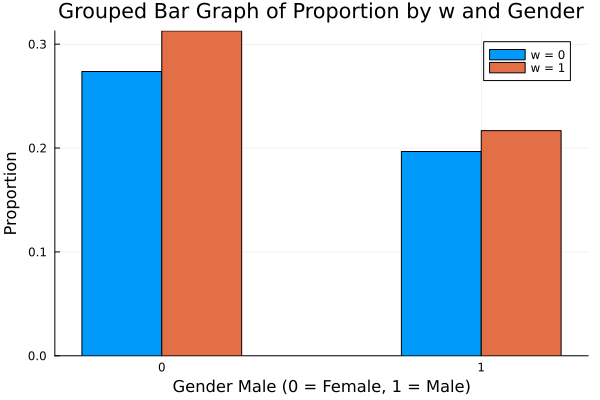

In [11]:
using DataFrames
using Plots

# Extracting the data
w = df_grouped.w
gender_male = df_grouped.gender_male
prop = df_grouped.prop

# Creating a grouped bar plot
groupedbar(
    string.(gender_male),
    prop,
    group = string.(w),
    xlabel = "Gender Male (0 = Female, 1 = Male)",
    ylabel = "Proportion",
    title = "Grouped Bar Graph of Proportion by w and Gender",
    legend = :topright,
    bar_width = 0.5,
    label = ["Treatment = 0" "Treatment = 1"]
)

# Display the plot
plot!(current())


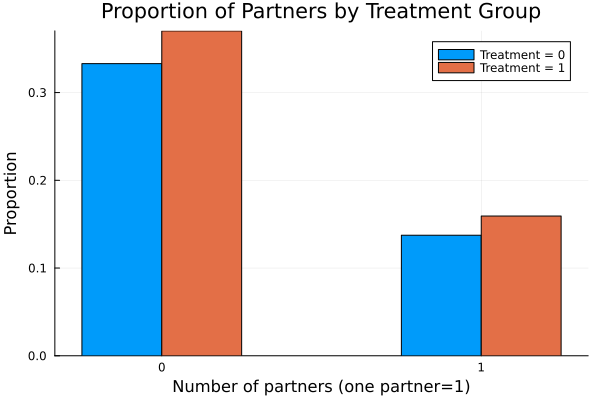

In [12]:
using DataFrames
using StatsPlots

# Group by 'w' and 'partners1' and count occurrences
df_grouped = combine(groupby(df, [:w, :partners1]), nrow => :count)

# Calculate the proportion of each group
df_grouped[!, :prop] .= df_grouped.count ./ sum(df_grouped.count)

# Extracting the data
w = df_grouped.w
partners1 = df_grouped.partners1
prop = df_grouped.prop

# Creating a grouped bar plot
groupedbar(
    string.(partners1),
    prop,
    group = string.(w),
    xlabel = "Number of partners (one partner=1)",
    ylabel = "Proportion",
    title = "Proportion of Partners by Treatment Group",
    legend = :topright,
    bar_width = 0.5,
    label = ["Treatment = 0" "Treatment = 1"]
)

# Display the plot
plot!(current())


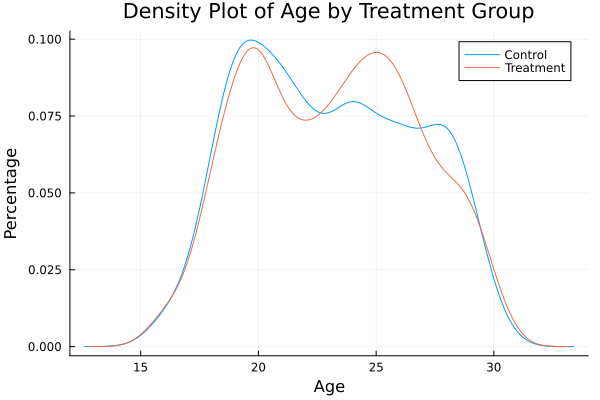

In [14]:
using DataFrames
using StatsPlots

# Create density plots for each group in 'w'
density(
    df.age,
    group = df.w,
    xlabel = "Age",
    ylabel = "Percentage",
    title = "Density Plot of Age by Treatment Group",
    legend = :topright,
    normalize = true,
    label = ["Control" "Treatment"]
)

# Display the plot
plot!(current())


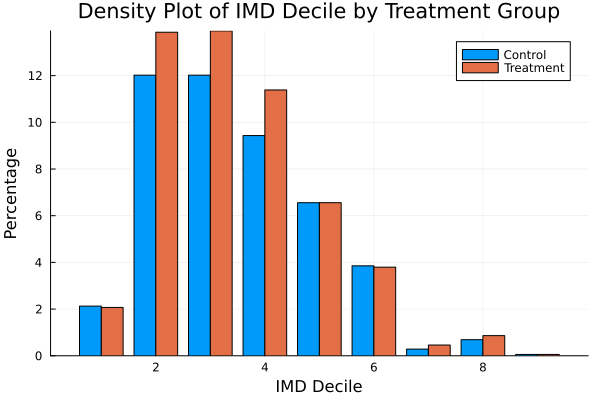

In [18]:
using DataFrames
using StatsPlots

# Group by 'imd_decile' and 'w' and count occurrences
df_grouped = combine(groupby(df, [:imd_decile, :w]), nrow => :count)

# Calculate the proportion of each group within 'imd_decile'
df_grouped[!, :prop] .= df_grouped.count ./ sum(df_grouped.count) * 100  # Convert to percentage

# Create a density-like bar plot
@df df_grouped groupedbar(
    :imd_decile,
    :prop,
    group = :w,
    xlabel = "IMD Decile",
    ylabel = "Percentage",
    title = "Density Plot of IMD Decile by Treatment Group",
    legend = :topright,
    bar_width = 0.8,
    label = ["Control" "Treatment"]
)

# Display the plot
plot!(current())


In [20]:
using DataFrames
using StatsModels
using GLM

model_1 = @formula(y ~ w)
est_1 = lm(model_1, df)

print(est_1)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + w

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.211491   0.0160531  13.17    <1e-37   0.180006   0.242977
w            0.265164   0.0220586  12.02    <1e-31   0.2219     0.308429
────────────────────────────────────────────────────────────────────────

In [21]:
model_2 = @formula(y ~ w + age + gender_female + ethnicgrp_white + ethnicgrp_black + ethnicgrp_mixed_multiple + partners1 + postlaunch + imd_decile)
est_2 = lm(model_2, df)

print(est_2)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + w + age + gender_female + ethnicgrp_white + ethnicgrp_black + ethnicgrp_mixed_multiple + partners1 + postlaunch + imd_decile

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                                Coef.  Std. Error      t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)               -0.163972    0.0880134   -1.86    0.0626  -0.336596    0.00865184
w                          0.255827    0.0217719   11.75    <1e-29   0.213125    0.298529
age                        0.0124373   0.00316801   3.93    <1e-04   0.0062238   0.0186509
gender_female              0.0928923   0.0223094    4.16    <1e-04   0.0491361   0.136649
ethnicgrp_white     

### 3. Non-Linear Methods DML

In [ ]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Statistics")
Pkg.add("StatsModels")
Pkg.add("GLM")
Pkg.add("MLJ")
Pkg.add("XGBoost")
Pkg.add("MLJXGBoostInterface")
Pkg.add("MLJGLMInterface")
Pkg.add("Lasso")
Pkg.add("GLMNet")
Pkg.add("CovarianceMatrices")

In [ ]:
using DataFrames
using CSV
using Statistics
using StatsModels
using GLM
using Random
using StatsBase
using LinearAlgebra


Precompiling CSV
  ✓ CSV
  1 dependency successfully precompiled in 9 seconds. 26 already precompiled.
Precompiling StatsModels
  ? StatsFuns
        Info Given StatsModels was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? StatsModels
[ Info: Precompiling StatsModels [3eaba693-59b7-5ba5-a881-562e759f1c8d]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing StatsModels [3eaba693-59b7-5ba5-a881-562e759f1c8d].
Precompiling StatsFuns
        Info Given StatsFuns was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? StatsFuns
[ Info: Precompiling StatsFuns [4c63d2b9-4356-54db-

In [ ]:

# Load the CSV file into a DataFrame
file_path = "C:\\Users\\juanl\\OneDrive\\Desktop\\hg\\data\\processed_esti.csv"
DML = CSV.read(file_path, DataFrame)

Random.seed!(1234)

# Split the data into training and testing sets
n = nrow(DML)
training = sample(1:n, round(Int, 0.75 * n), replace=false)
data_train = DML[training, :]
data_test = DML[setdiff(1:n, training), :]

# Extract the test outcome
Y_test = data_test.y

# Extract matrices for outcome, treatment, and controls
y = reshape(data_train[:, 1], :, 1)         # outcome: growth rate
d = reshape(data_train[:, 2], :, 1)         # treatment: initial wealth
x = Matrix(data_train[:, Not([1, 2])])      # controls: country characteristics

# Display the first few rows to verify
println("First few rows of y:")
println(y[1:5, :])
println("First few rows of d:")
println(d[1:5, :])
println("First few rows of x:")
println(x[1:5, :])



First few rows of y:
[0; 0; 0; 0; 1;;]
First few rows of d:
[1; 1; 0; 1; 1;;]
First few rows of x:
[1 0 0 0 0 0 0 1 1 0 0 25 6; 0 1 0 0 0 0 0 1 0 0 1 28 5; 1 0 0 0 0 0 0 1 1 1 0 17 6; 1 0 0 0 0 0 0 1 0 1 0 25 2; 1 0 0 0 0 0 0 1 0 0 0 23 2]


In [ ]:
using Pkg
Pkg.add("DecisionTree")

using DecisionTree



   Resolving package versions...
   Installed ScikitLearnBase ─ v0.5.0
   Installed DecisionTree ──── v0.12.4
    Updating `C:\Users\juanl\.julia\environments\v1.10\Project.toml`
  [7806a523] + DecisionTree v0.12.4
    Updating `C:\Users\juanl\.julia\environments\v1.10\Manifest.toml`
  [7806a523] + DecisionTree v0.12.4
  [6e75b9c4] + ScikitLearnBase v0.5.0
Precompiling project...
  ? StatsFuns
  ✓ ScikitLearnBase
  ✓ ColorVectorSpace → SpecialFunctionsExt
  ✗ PyCall
  ✗ BinaryProvider
  ✓ Latexify → DataFramesExt
  ✗ MLJXGBoostInterface
  ✓ DecisionTree
  ✗ Snappy
  ? StatsModels
  ? Distributions
  ✗ ExcelReaders
  ✗ Parquet
  ? GLM
  ? CovarianceMatrices
  ✗ ExcelFiles
  ? GLMNet
  ✗ ParquetFiles
  ? MLJGLMInterface
  ? MLJBase
  ? Lasso
  ✗ Queryverse
  ? MLJIteration
  ? MLJModels
  ? MLJTuning
  ? MLJSerialization
  ? MLJEnsembles
  ? MLJ
  4 dependencies successfully precompiled in 42 seconds. 284 already precompiled.
  12 dependencies precompiled but different versions are curre

### DML function for Regression tree

In [ ]:

using DecisionTree
using Statistics

function DML2_for_PLM_tree(data_train, dreg, yreg; nfold=10)
    nobs = nrow(data_train)  # number of observations
    foldid = repeat(1:nfold, ceil(Int, nobs/nfold))[shuffle(1:nobs)]  # define fold indices
    I = [findall(foldid .== i) for i in 1:nfold]  # split observation indices into folds
    ytil = fill(NaN, nobs)
    dtil = fill(NaN, nobs)
    println("fold: ")

    for b in 1:nfold
        # Exclude the current fold for training
        datitanow = data_train[setdiff(1:nobs, I[b]), Not(:d)]
        datitanoy = data_train[setdiff(1:nobs, I[b]), Not(:y)]
        # Current fold for prediction
        datitanowpredict = data_train[I[b], Not(:d)]
        datitanoypredict = data_train[I[b], Not(:y)]

        # Fit models
        dfit = dreg(datitanoy)
        yfit = yreg(datitanow)
        # Make predictions
        dhat = predict(dfit, DataFrame(datitanoypredict, :auto))
        yhat = predict(yfit, DataFrame(datitanowpredict, :auto))
        # Record residuals
        dtil[I[b]] .= data_train[I[b], :d] .- dhat
        ytil[I[b]] .= data_train[I[b], :y] .- yhat
        print("$b ")
    end

    # Ensure ytil and dtil are column vectors
    ytil = reshape(ytil, :, 1)
    dtil = reshape(dtil, :, 1)

    # Regress one residual on the other
    rfit = lm(@formula(ytil ~ dtil), DataFrame(hcat(ytil, dtil), :auto))
    coef_est = coef(rfit)[2]
    se = sqrt(vcov(HC0, rfit)[2, 2])
    println("\ncoef (se) = $coef_est ($se)")

    return (coef_est = coef_est, se = se, dtil = dtil, ytil = ytil)
end

DML2_for_PLM_tree (generic function with 1 method)

### DML function for Boosting Trees

In [ ]:

using MLJ
using XGBoost

function DML2_for_PLM_boosttree(data_train, dreg, yreg; nfold=10)
    nobs = nrow(data_train)  # number of observations
    foldid = repeat(1:nfold, ceil(Int, nobs/nfold))[shuffle(1:nobs)]  # define fold indices
    I = [findall(foldid .== i) for i in 1:nfold]  # split observation indices into folds
    ytil = fill(NaN, nobs)
    dtil = fill(NaN, nobs)
    println("fold: ")

    for b in 1:nfold
        # Exclude the current fold for training
        datitanow = data_train[setdiff(1:nobs, I[b]), Not(:d)]
        datitanoy = data_train[setdiff(1:nobs, I[b]), Not(:y)]
        # Current fold for prediction
        datitanowpredict = data_train[I[b], Not(:d)]
        datitanoypredict = data_train[I[b], Not(:y)]

        # Fit models
        dfit = dreg(datitanoy)
        best_boostt = fit!(dfit, verbosity=0)  # fit the model
        yfit = yreg(datitanow)
        best_boosty = fit!(yfit, verbosity=0)  # fit the model

        # Make predictions
        dhat = MLJ.predict(best_boostt, DataFrame(datitanoypredict, :auto))
        yhat = MLJ.predict(best_boosty, DataFrame(datitanowpredict, :auto))

        # Record residuals
        dtil[I[b]] .= data_train[I[b], :d] .- dhat
        ytil[I[b]] .= data_train[I[b], :y] .- yhat
        print("$b ")
    end

    # Ensure ytil and dtil are column vectors
    ytil = reshape(ytil, :, 1)
    dtil = reshape(dtil, :, 1)

    # Regress one residual on the other
    rfit = lm(@formula(ytil ~ dtil), DataFrame(hcat(ytil, dtil), :auto))
    coef_est = coef(rfit)[2]
    se = sqrt(vcov(HC0, rfit)[2, 2])
    println("\ncoef (se) = $coef_est ($se)")

    return (coef_est = coef_est, se = se, dtil = dtil, ytil = ytil)
end


DML2_for_PLM_boosttree (generic function with 1 method)

### DML function for Lasso

In [ ]:


using DataFrames
using CSV
using GLM
using Random
using StatsBase
using GLMNet
using Statistics

function DML2_for_PLM(x, d, y, dreg, yreg; nfold=10)
    nobs = size(x, 1)  # number of observations
    foldid = repeat(1:nfold, ceil(Int, nobs/nfold))[shuffle(1:nobs)]  # define fold indices
    I = [findall(foldid .== i) for i in 1:nfold]  # split observation indices into folds
    ytil = fill(NaN, nobs)
    dtil = fill(NaN, nobs)
    println("fold: ")

    for b in 1:nfold
        # Exclude the current fold for training
        train_indices = setdiff(1:nobs, I[b])
        test_indices = I[b]

        # Fit models
        dfit = dreg(x[train_indices, :], d[train_indices])
        yfit = yreg(x[train_indices, :], y[train_indices])

        # Make predictions
        dhat = GLMNet.predict(dfit, x[test_indices, :])
        yhat = GLMNet.predict(yfit, x[test_indices, :])

        # Record residuals
        dtil[test_indices] .= d[test_indices] .- dhat
        ytil[test_indices] .= y[test_indices] .- yhat
        print("$b ")
    end

    # Ensure ytil and dtil are column vectors
    ytil = vec(ytil)
    dtil = vec(dtil)

    # Regress one residual on the other
    data = DataFrame(ytil = ytil, dtil = dtil)
    rfit = lm(@formula(ytil ~ dtil), data)
    coef_est = coef(rfit)[2]
    se = sqrt(vcov(HC0, rfit)[2, 2])
    println("\ncoef (se) = $coef_est ($se)")

    return Dict("coef.est" => coef_est, "se" => se, "dtil" => dtil, "ytil" => ytil)
end

DML2_for_PLM (generic function with 1 method)

#### 3.1. Lasso

In [ ]:


# Define Lasso regression functions
dreg_lasso = (x, d) -> GLMNet.glmnet(x, d, alpha=1.0, lambda=[0.1])
yreg_lasso = (x, y) -> GLMNet.glmnet(x, y, alpha=1.0, lambda=[0.1])

# Apply DML with Lasso
DML2_lasso = DML2_for_PLM(x, d, y, dreg_lasso, yreg_lasso, nfold=10)

# Extract results
coef_lasso = DML2_lasso["coef.est"]
se_lasso = DML2_lasso["se"]
prRes_lassoD = mean((DML2_lasso["dtil"]).^2)
prRes_lassoY = mean((DML2_lasso["ytil"]).^2)

# Format results
prRes_lasso = DataFrame(
    Estimate = coef_lasso,
    `Standard Error` = se_lasso,
    `RMSE D` = sqrt(prRes_lassoD),
    `RMSE Y` = sqrt(prRes_lassoY)
)

# Display the results
println(prRes_lasso)


fold: 
1 2 3 4 5 6 7 8 9 10 

LoadError: UndefVarError: `coef` not defined

The message treatment providing information about Internet-accessed sexually transmitted
infection testing predicts an increase in the probability that a person will get tested
by 25.13 percentage points compared to receiving information about nearby clinics offering
in-person testing.
By providing both groups with information about testing, we mitigate the potential reminder
effect, as both groups are equally prompted to consider testing. This approach allows us to
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality
rather than mere correlation, confirming that the intervention's effect is driven by the unique
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and
convenience

#### 3.2. Regression Trees

In [ ]:

# Set up the basic formula for the regression tree
X_basic = "gender_transgender + ethnicgrp_asian + ethnicgrp_black + ethnicgrp_mixed_multiple+ ethnicgrp_other + ethnicgrp_white + partners1 + postlaunch + msm + age+ imd_decile"
y_form_tree = @formula(y ~ $(Meta.parse(X_basic)))
t_form_tree = @formula(w ~ $(Meta.parse(X_basic)))

# Define tree regression functions
yreg_tree = (dataa) -> DecisionTreeRegressor(min_samples_leaf=5, max_depth=5).fit(Matrix(dataa[:, Not(:y)]), Vector(dataa[:, :y]))
treg_tree = (dataa) -> DecisionTreeRegressor(min_samples_leaf=5, max_depth=5).fit(Matrix(dataa[:, Not(:w)]), Vector(dataa[:, :w]))

# Apply DML with regression tree
DML2_tree = DML2_for_PLM_tree(data_train, treg_tree, yreg_tree, nfold=10)

# Extract results
coef_tree = DML2_tree[1]
se_tree = DML2_tree[2]
prRes_treeD = mean((DML2_tree[3]).^2)
prRes_treeY = mean((DML2_tree[4]).^2)

# Format results
prRes_tree = DataFrame(
    Estimate = coef_tree,
    `Standard Error` = se_tree,
    `RMSE D` = sqrt(prRes_treeD),
    `RMSE Y` = sqrt(prRes_treeY)
)

# Display the results
println(prRes_tree)

LoadError: LoadError: ArgumentError: interpolation with $ not supported in @formula.  Use @eval @formula(...) instead.
in expression starting at In[23]:4

The message treatment providing information about Internet-accessed sexually transmitted
infection testing predicts an increase in the probability that a person will get tested
by 23.08 percentage points compared to receiving information about nearby clinics offering
in-person testing.
By providing both groups with information about testing, we mitigate the potential reminder
effect, as both groups are equally prompted to consider testing. This approach allows us to
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality
rather than mere correlation, confirming that the intervention's effect is driven by the unique
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and
convenience

#### 3.3. Boosting Trees

In [ ]:
# Set up the basic formula for the boosted tree
X_basic = "gender_transgender + ethnicgrp_asian + ethnicgrp_black + ethnicgrp_mixed_multiple+ ethnicgrp_other + ethnicgrp_white + partners1 + postlaunch + msm + age+ imd_decile"
y_form_tree = @formula(y ~ $(Meta.parse(X_basic)))
t_form_tree = @formula(w ~ $(Meta.parse(X_basic)))

# Define boosted tree regression functions
yreg_treeboost = (dataa) -> machine(XGBoostRegressor(max_depth=2, nrounds=1000, eta=0.01, subsample=0.5), dataa[:, Not(:y)], dataa[:, :y])
treg_treeboost = (dataa) -> machine(XGBoostRegressor(max_depth=2, nrounds=1000, eta=0.01, subsample=0.5), dataa[:, Not(:w)], dataa[:, :w])

# Apply DML with boosted trees
DML2_boosttree = DML2_for_PLM_boosttree(data_train, treg_treeboost, yreg_treeboost, nfold=10)

# Extract results
coef_boosttree = DML2_boosttree[1]
se_boosttree = DML2_boosttree[2]
prRes_boosttreeD = mean((DML2_boosttree[3]).^2)
prRes_boosttreeY = mean((DML2_boosttree[4]).^2)

# Format results
prRes_boosttree = DataFrame(
    Estimate = coef_boosttree,
    `Standard Error` = se_boosttree,
    `RMSE D` = sqrt(prRes_boosttreeD),
    `RMSE Y` = sqrt(prRes_boosttreeY)
)

# Display the results
println(prRes_boosttree)

LoadError: LoadError: ArgumentError: interpolation with $ not supported in @formula.  Use @eval @formula(...) instead.
in expression starting at In[25]:3

The message treatment providing information about Internet-accessed sexually transmitted
infection testing predicts an increase in the probability that a person will get tested
by 25.28 percentage points compared to receiving information about nearby clinics offering
in-person testing.
By providing both groups with information about testing, we mitigate the potential reminder
effect, as both groups are equally prompted to consider testing. This approach allows us to
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality
rather than mere correlation, confirming that the intervention's effect is driven by the unique
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and
convenience

#### 3.4. Random Forest

In [ ]:
# Function for Double Machine Learning with Partially Linear Model using Random Forest
function DML2_for_PLM_RF(data_train, dreg, yreg; nfold=10)
    nobs = nrow(data_train)  # number of observations
    foldid = repeat(1:nfold, ceil(Int, nobs/nfold))[shuffle(1:nobs)]  # define fold indices
    I = [findall(foldid .== i) for i in 1:nfold]  # split observation indices into folds
    ytil = fill(NaN, nobs)
    dtil = fill(NaN, nobs)
    println("fold: ")

    for b in 1:nfold
        # Exclude the current fold for training
        train_indices = setdiff(1:nobs, I[b])
        test_indices = I[b]

        # Fit models
        dfit = dreg(x[train_indices, :], d[train_indices])
        yfit = yreg(x[train_indices, :], y[train_indices])

        # Make predictions
        dhat = predict(dfit, x[test_indices, :])
        yhat = predict(yfit, x[test_indices, :])

        # Record residuals
        dtil[test_indices] .= d[test_indices] .- dhat
        ytil[test_indices] .= y[test_indices] .- yhat
        print("$b ")
    end

    # Ensure ytil and dtil are column vectors
    ytil = vec(ytil)
    dtil = vec(dtil)

    # Regress one residual on the other
    data = DataFrame(ytil = ytil, dtil = dtil)
    rfit = lm(@formula(ytil ~ dtil), data)
    coef_est = coef(rfit)[2]
    se = sqrt(vcov(HC0, rfit)[2, 2])
    println("\ncoef (se) = $coef_est ($se)")

    return Dict("coef.est" => coef_est, "se" => se, "dtil" => dtil, "ytil" => ytil)
end

DML2_for_PLM_RF (generic function with 1 method)

In [ ]:

# Define Random Forest regression functions
dreg_RF = (x, d) -> RandomForestRegressor(n_trees=100).fit(x, d)
yreg_RF = (x, y) -> RandomForestRegressor(n_trees=100).fit(x, y)

# Apply DML with Random Forest
DML2_RF = DML2_for_PLM_RF(x, d, y, dreg_RF, yreg_RF, nfold=10)

# Extract results
coef_RF = DML2_RF["coef.est"]
se_RF = DML2_RF["se"]
prRes_RFD = mean((DML2_RF["dtil"]).^2)
prRes_RFY = mean((DML2_RF["ytil"]).^2)

# Format results
prRes_RF = DataFrame(
    Estimate = coef_RF,
    `Standard Error` = se_RF,
    `RMSE D` = sqrt(prRes_RFD),
    `RMSE Y` = sqrt(prRes_RFY)
)

# Display the results
println(prRes_RF)

LoadError: MethodError: no method matching DML2_for_PLM_RF(::Matrix{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::var"#55#56", ::var"#57#58"; nfold::Int64)

[0mClosest candidates are:
[0m  DML2_for_PLM_RF(::Any, ::Any, ::Any; nfold)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[26]:2[24m[39m


The message treatment providing information about Internet-accessed sexually transmitted
infection testing predicts an increase in the probability that a person will get tested
by 24.14 percentage points compared to receiving information about nearby clinics offering
in-person testing.
By providing both groups with information about testing, we mitigate the potential reminder
effect, as both groups are equally prompted to consider testing. This approach allows us to
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality
rather than mere correlation, confirming that the intervention's effect is driven by the unique
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and
convenience

#### 3.5. Table and Coefficient plot

##### Table

##### Coefficient Plot

In [ ]:
prRes_D = [
    mean((DML2_lasso["dtil"]).^2),
    mean((DML2_tree["dtil"]).^2),
    mean((DML2_boosttree["dtil"]).^2),
    mean((DML2_RF["dtil"]).^2)
]

prRes_Y = [
    mean((DML2_lasso["ytil"]).^2),
    mean((DML2_tree["ytil"]).^2),
    mean((DML2_boosttree["ytil"]).^2),
    mean((DML2_RF["ytil"]).^2)
]

prRes = hcat(sqrt.(prRes_D), sqrt.(prRes_Y))
rownames!(prRes, ["RMSE D", "RMSE Y"])
colnames!(prRes, ["Lasso", "Reg Tree", "Boost Tree", "Random Forest"])

# Create results table
table = zeros(4, 4)

# Point Estimate
table[1, 1] = DML2_lasso["coef.est"]
table[2, 1] = DML2_tree["coef.est"]
table[3, 1] = DML2_boosttree["coef.est"]
table[4, 1] = DML2_RF["coef.est"]

# SE
table[1, 2] = DML2_lasso["se"]
table[2, 2] = DML2_tree["se"]
table[3, 2] = DML2_boosttree["se"]
table[4, 2] = DML2_RF["se"]

# RMSE Y
table[1, 3] = prRes[2, 1]
table[2, 3] = prRes[2, 2]
table[3, 3] = prRes[2, 3]
table[4, 3] = prRes[2, 4]

# RMSE D
table[1, 4] = prRes[1, 1]
table[2, 4] = prRes[1, 2]
table[3, 4] = prRes[1, 3]
table[4, 4] = prRes[1, 4]

# Print results
colnames!(table, ["Estimate", "Standard Error", "RMSE Y", "RMSE D"])
rownames!(table, ["Lasso", "Reg Tree", "Boost Tree", "Random Forest"])

# Display the table
println(table)


LoadError: UndefVarError: `DML2_lasso` not defined

In [ ]:
using Pkg
Pkg.add("Plots")
using plots

   Resolving package versions...
  No Changes to `C:\Users\juanl\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\juanl\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ? StatsFuns
  ? StatsModels
  ? Distributions
  ? GLM
  ? CovarianceMatrices
  ? GLMNet
  ? MLJGLMInterface
  ? MLJBase
  ? Lasso
  ? MLJIteration
  ? MLJTuning
  ? MLJEnsembles
  ? MLJSerialization
  ? MLJModels
  ? MLJ


LoadError: ArgumentError: Package plots not found in current path.
- Run `import Pkg; Pkg.add("plots")` to install the plots package.

In [ ]:
# Convert `table` to DataFrame
table_ci = DataFrame(table, ["Estimate", "Standard Error", "RMSE Y", "RMSE D"])
table_ci.Method = ["Lasso", "Reg Tree", "Boost Tree", "Random Forest"]

# Calculate confidence intervals
table_ci.CI_Lower_1 = table_ci.Estimate .- 2.576 .* table_ci."Standard Error"
table_ci.CI_Upper_1 = table_ci.Estimate .+ 2.576 .* table_ci."Standard Error"
table_ci.CI_Lower_5 = table_ci.Estimate .- 1.96 .* table_ci."Standard Error"
table_ci.CI_Upper_5 = table_ci.Estimate .+ 1.96 .* table_ci."Standard Error"
table_ci.CI_Lower_10 = table_ci.Estimate .- 1.645 .* table_ci."Standard Error"
table_ci.CI_Upper_10 = table_ci.Estimate .+ 1.645 .* table_ci."Standard Error"

# Plotting
plot(table_ci.Method, table_ci.Estimate, seriestype=:scatter, label="Estimate", markersize=4)
plot!(table_ci.Method, table_ci.CI_Lower_5, ribbon=(table_ci.CI_Upper_5 .- table_ci.CI_Lower_5), label="95% CI", lw=2, lc=:blue, alpha=0.7)
plot!(table_ci.Method, table_ci.CI_Lower_10, ribbon=(table_ci.CI_Upper_10 .- table_ci.CI_Lower_10), label="90% CI", lw=2, lc=:red, alpha=0.7)
plot!(table_ci.Method, table_ci.CI_Lower_1, ribbon=(table_ci.CI_Upper_1 .- table_ci.CI_Lower_1), label="99% CI", lw=2, lc=:green, alpha=0.7)
title!("Estimated Coefficients with Confidence Intervals")
xlabel!("Method")
ylabel!("Estimate")
theme(:minimal)
xticks!(1:4, table_ci.Method)
xrotation!(45)


LoadError: MethodError: no method matching DataFrame(::typeof(table), ::Vector{String})

[0mClosest candidates are:
[0m  DataFrame([91m::AbstractVector{<:Type}[39m, ::AbstractVector{<:AbstractString}, [91m::Integer[39m; makeunique)
[0m[90m   @[39m [36mDataFrames[39m [90mC:\Users\juanl\.julia\packages\DataFrames\JZ7x5\src\dataframe\[39m[90m[4mdataframe.jl:397[24m[39m
[0m  DataFrame([91m::AbstractVector{<:AbstractVector}[39m, ::AbstractVector; makeunique, copycols)
[0m[90m   @[39m [36mDataFrames[39m [90mC:\Users\juanl\.julia\packages\DataFrames\JZ7x5\src\dataframe\[39m[90m[4mdataframe.jl:344[24m[39m
[0m  DataFrame([91m::AbstractVector{<:Type}[39m, ::AbstractVector{<:AbstractString}; ...)
[0m[90m   @[39m [36mDataFrames[39m [90mC:\Users\juanl\.julia\packages\DataFrames\JZ7x5\src\dataframe\[39m[90m[4mdataframe.jl:397[24m[39m
[0m  ...


#### 3.6. Model

To choose the best model, we must compare the RMSEs of the outcome variable Y. In this case, the model with the lowest RMSE for Y
is generated by Lasso (0.4716420), whereas the lowest for the treatment is generated by Boosting Trees (0.4983734). Therefore, DML
could be employed with Y cleaned using Lasso and the treatment using Boosting Trees.